# Aplicaciones de programación dinámica para computar políticas óptimas

En este trabajo vamos a aplicar técnicas de programación dinámica para obtener una política óptima en el problema de administrar un negocio de alquiler de autos. En particular vamos a utilizar el algoritmo de **Iteración de Politica**.

En general, para poder utilizar programación dinámica se requiere modelar el problema como un **Proceso de Decisión de Markov** (o **MDP** por sus siglas en inglés), con lo cuál debemos conocer perfectamente todos los posibles estados, acciones, recompensas y las probabilidades de transición entre ellos. En particular vamos a suponer que tenemos un **MDP** finito, es decir, que sus conjuntos de estados, acciones y recompensas, $\mathcal{S}$, $\mathcal{A}$ y $\mathcal{R}$ son finitos y que sus dinámicas están dadas por las probabilidades $p(s',r|s,a)$ para todo $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$, $r \in \mathcal{R}$ y $s' \in \mathcal{S}$.

### Problema

El problema que vamos a modelar y resolver es el que se presenta en el capítulo 4 del Sutton & Barto como Alquiler de Autos de Jack:

*Jack administra dos sucursales de una empresa nacional de alquiler de autos. Cada día, un cierto número de clientes llega a cada sucursal para alquilar autos. Si Jack tiene un automóvil disponible, lo alquila y la compañía le acredita $\$10$. Si no le quedan autos en alguna de las sucursales y llega un cliente, entonces la oportunidad de hacer ese alquiler se pierde. Los autos están disponibles para alquilar al día siguiente de su devolución. Para ayudar a garantizar que los autos estén disponibles donde se los necesita, Jack puede moverlos entre las dos sucursales durante la noche, a un costo de $\$2$ por automóvil movido. Supongamos que el número de autos solicitados y devueltos en cada ubicación son variables aleatorias de Poisson, lo que significa que la probabilidad de que el número sea $n$ es $\frac{\lambda^n}{n!}e^{-\lambda}$ donde $\lambda$ es el número esperado. Suponemos que $\lambda$ es 3 y 4 para las solicitudes de alquiler en la primera y segunda sucursal, respectivamente, y 3 y 2 para devoluciones. Para simplificar un poco el problema, asumimos que no puede haber más de 20 automóviles en cada ubicación (los automóviles adicionales se devuelven a la empresa nacional y, por lo tanto, desaparecen del problema) y se puede mover un máximo de 5 automóviles de una ubicación a la otra en una noche.*

### Modelado

Vamos a modelar este problema como un **MDP** finito y continuo con una tasa de descuento $\gamma = 0.9$ de la siguiente manera: cada día es una unidad de tiempo, el estado es el número de autos en cada sucursal al final del día y las acciones son los números netos de automóviles que se movieron entre las dos ubicaciones durante la noche.

Comenzamos con los imports que vamos a necesitar:

In [1]:
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns
from scipy.stats import poisson

sns.set_theme()
scalar_mapable = cm.ScalarMappable(cmap = "viridis")
plt.rcParams.update({
    "mathtext.fontset": "cm",
})
rng = np.random.default_rng(1234)

Luego definimos las constantes del problema, incluyendo tablas (numpy arrays) con las probabilidades de Poisson que vamos a usar pre-computadas para reducir el costo computacional:

In [2]:
MAX_CARS = 20

REQUESTS_LAMBDA_1, REQUESTS_LAMBDA_2 = 3, 4
RETURNS_LAMBDA_1, RETURNS_LAMBDA_2 = 3, 2

REQUESTS_VAR_1, REQUESTS_VAR_2 = poisson(REQUESTS_LAMBDA_1), poisson(REQUESTS_LAMBDA_2)
RETURNS_VAR_1, RETURNS_VAR_2 = poisson(RETURNS_LAMBDA_1), poisson(RETURNS_LAMBDA_2)

REQUESTS_PROB_1 = np.array([REQUESTS_VAR_1.pmf(i) for i in range(MAX_CARS)] + [REQUESTS_VAR_1.sf(MAX_CARS - 1)])
REQUESTS_PROB_2 = np.array([REQUESTS_VAR_2.pmf(i) for i in range(MAX_CARS)] + [REQUESTS_VAR_2.sf(MAX_CARS - 1)])
RETURNS_PROB_1 = np.array([RETURNS_VAR_1.pmf(i) for i in range(MAX_CARS)] + [RETURNS_VAR_1.sf(MAX_CARS - 1)])
RETURNS_PROB_2 = np.array([RETURNS_VAR_2.pmf(i) for i in range(MAX_CARS)] + [RETURNS_VAR_2.sf(MAX_CARS - 1)])

CAR_RENTAL_STATES = list(product(range(MAX_CARS + 1), range(MAX_CARS + 1)))




A continuación, desarrollamos la función de acciones posibles a partir de cierto estado, $\mathcal{A}(s)$ y la función de acción-valor $q_\pi(s,a)$ dada por la ecuación 

$$
q_\pi(s,a) \doteq \mathbb{E}[R_{t+1} + \gamma v_\pi(S_{t+1}) | S_t=s,A_t=a] = \sum_{s',r} p(s',r|s,a)[r + \gamma v_\pi(s') ]
$$

y dado que en nuestro caso, $s' = f(req_1,req_2,ret_1,ret_2)$ y $r = g(req_1,req_2,ret_1,ret_2)$ para ciertas $f$ y $g$ dadas, con $req_1,req_2,ret_1,ret_2$ variables aleatorias independientes, la ecuación anterior se convierte en:

$$
q_\pi(s,a) = \sum_{req_1,req_2,ret_1,ret_2} p(req_1,req_2,ret_1,ret_2|s,a)[g(req_1,req_2,ret_1,ret_2) + \gamma v_\pi(f(req_1,req_2,ret_1,ret_2)) ]
$$

Como simplificación extra, dado el alto costo computacional de calcular la función acción-valor iterando sobre el espacio de las 4 variables aleatorias independientes que mencionamos, dejaremos constantes la cantidad de autos retornada en ambas sucursales ($ret_1$ y $ret_2$, fijadas en el valor esperado, es decir $\lambda$, 3 y 2 respectivamente en este caso) y así iterar únicamente sobre las variables de autos solicitados ($req_1$ y $req_2$) y que el método termine en un tiempo razonable.

Vamos a modelar el estado $s$ como una tupla (int, int) entre 0 y 20 que representan cuantos autos hay al final del dia en las sucursales 1 y 2 respectivamente. $V$ como un numpy array de 21x21 que representa la estimacion actual de la funcion estado-valor para cada posible estado (las filas corresponden a la sucursal 1 y las columnas a la sucursal 2). Y la accion $a$ es un int entre -5 y 5 que representa cuantos autos mueve Jack de la sucursal 1 a la 2 (numeros negativos indican que el movimiento se realiza desde la sucursal 2 hacia la 1).

In [3]:
# Funcion que devuelve una lista de posibles acciones a partir de un estado dado
def A_car_rental(s):
    num_cars_1, num_cars_2 = s
    
    return np.arange(-min(num_cars_2, 5), min(num_cars_1, 5) + 1)


# Estimacion de la funcion de accion-valor
def q_car_rental(V, s, a, const_returns=True):
    num_cars_1, num_cars_2 = s

    range_returned_1 = range(MAX_CARS + 1) if not const_returns else [RETURNS_LAMBDA_1]
    range_returned_2 = range(MAX_CARS + 1) if not const_returns else [RETURNS_LAMBDA_2]

    num_cars_start_1, num_cars_start_2 = min(num_cars_1 - a, MAX_CARS), min(num_cars_2 + a, MAX_CARS)

    expected_reward = 0.
    for requested_1, requested_2, returned_1, returned_2 in product(range(MAX_CARS + 1), range(MAX_CARS + 1), range_returned_1, range_returned_2):
        prob = REQUESTS_PROB_1[requested_1]*REQUESTS_PROB_2[requested_2]
        if not const_returns:
            prob *= RETURNS_PROB_1[returned_1]*RETURNS_PROB_2[returned_2]

        num_cars_rented_1, num_cars_rented_2 = min(num_cars_start_1, requested_1), min(num_cars_start_2, requested_2)
 
        r = 10*(num_cars_rented_1 + num_cars_rented_2) - 2*abs(a)

        num_cars_end_1 = min(num_cars_start_1 - num_cars_rented_1 + returned_1, MAX_CARS)
        num_cars_end_2 = min(num_cars_start_2 - num_cars_rented_2 + returned_2, MAX_CARS)
        
        expected_reward += prob*(r + 0.9*V[num_cars_end_1 - 1][num_cars_end_2 - 1])

    return expected_reward

Comenzaremos la iteración con la política que nunca mueve autos de una sucursal a otra, es decir $\pi(s)=0$ para todo $s \in \mathcal{S}$, y asignaremos valores aleatorios a la función estado-valor $V(s)$:

In [4]:
# Devolvemos una tupla (np.ndarray, np.ndarray) de matrices de tamaño (MAX_CARS+1)x(MAX_CARS+1) 
#que representan la funcion de estado-valor y la politica iniciales.

def initialization_car_rental():
    return rng.random((MAX_CARS + 1, MAX_CARS + 1)), np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

Definimos algunas funciones para graficar las iteraciones de la policy y la función estado-valor:

In [5]:
def init_plots_car_rental():
    fig = plt.figure()
    fig.set_size_inches(15, 10)

    axs = [
        fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233),
        fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236, projection='3d'),
    ]

    return axs


def plot_policy_car_rental(policy, i, ax):
    ax.clear()
    sns.heatmap(policy[::-1, :], ax=ax, vmin=-5, vmax=5, annot=True, square=True)
    ax.set_ylabel('#Autos en la primer sucursal', fontsize=15)
    ax.set_yticklabels(list(reversed(range(MAX_CARS + 1))))
    ax.set_xlabel('#Autos en la segunda sucursal', fontsize=15)
    ax.set_title(f'$\pi_{i}$', fontsize=20)
    

def plot_state_values_car_rental(V, i, ax):
    ax.set_ylabel('#Autos en la primer sucursal', fontsize=10)
    ax.set_xlabel('#Autos en la segunda sucursal', fontsize=10)
    ax.set_title(f'$v_{{\pi_{i}}}$', fontsize=20)
    
    x, y = np.arange(21), np.arange(21)
    X, Y = np.meshgrid(x, y)
    Z = V

    colors = scalar_mapable.to_rgba(Z)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors, linewidth=0, antialiased=True)

    plt.show()

A continuación desarrollamos el algoritmo de **Iteración de Política**. Este algoritmo garantiza que cada política es una mejora estricta con respecto a la anterior (a menos que ya sea óptima). Debido a que un MDP finito tiene solo un número finito de políticas, este proceso debe converger hacia una política óptima y una función de valor óptima en un número finito de iteraciones.

In [6]:
def policy_evaluation(V, policy, q, S, theta):
    while True:
        delta = 0.
        for s in S:
            v = V[s]
            V[s] = q(V, s, policy[s])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
            
def policy_improvement(V, policy, q, A, S):
    policy_stable = True
    for s in S:
        old_action = policy[s]
        actions = A(s)
        action_values = [q(V, s, a) for a in actions]
        max_idx = np.argmax(action_values)
        if action_values[max_idx] > action_values[np.where(actions==old_action)[0].item()]:
            policy[s] = actions[max_idx]
            policy_stable = False
    
    return policy_stable


def policy_iteration(initialization, q, A, S, init_plots, plot_policy, plot_state_values, theta=0.1):
    V, policy = initialization()
    axs = init_plots()
    i = 0
    plot_policy(policy, i, axs[i])
    policy_stable = False
    while not policy_stable:
        policy_evaluation(V, policy, q, S, theta)
        policy_stable = policy_improvement(V, policy, q, A, S)
        i += 1
        if not policy_stable:
            plot_policy(policy, i, axs[i])
        else:
            plot_state_values(V, i-1, axs[i])

    return V, policy

### Ejecución

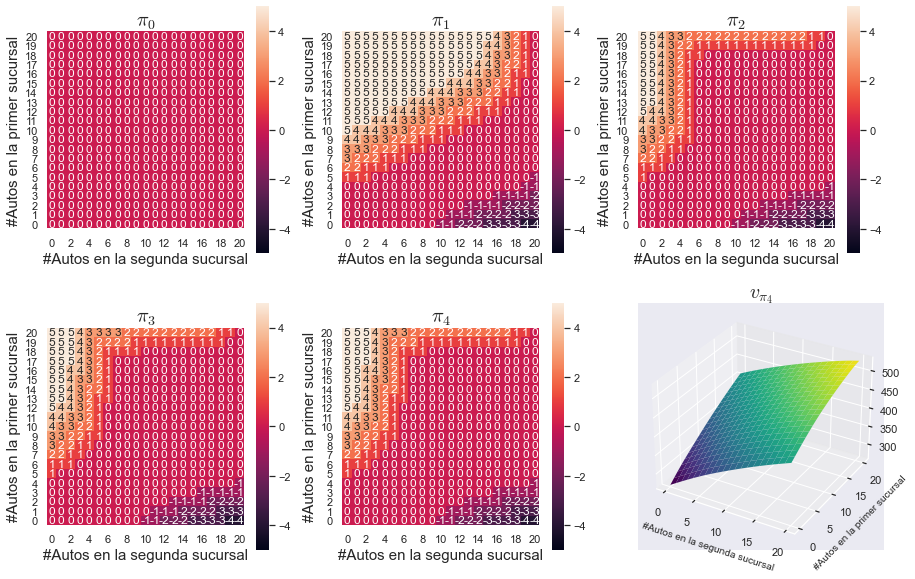

In [7]:
V, policy = policy_iteration(initialization=initialization_car_rental, q=q_car_rental, A=A_car_rental, S=CAR_RENTAL_STATES, 
                             init_plots=init_plots_car_rental, plot_policy=plot_policy_car_rental, plot_state_values=plot_state_values_car_rental, theta=0.1)

En el gráfico vemos la secuencia de políticas encontradas por el algoritmo de iteración de política para el problema de alquiler de autos de Jack,
y la función estado-valor final. Los primeros cinco diagramas muestran, para cada número de autos en cada ubicación al final del día, la cantidad de autos a mover de la primera sucursal a la segunda (como dijimos, los números negativos indican transferencias de la segunda sucursal a la primera). Cada política sucesiva es una mejora estricta con respecto a la política anterior, y la última política es óptima.

Como se menciona en el libro, el algoritmo de iteración de política a veces converge en muy pocas iteraciones, como en este caso que converge en solo 4 iteraciones. A los efectos prácticos, la política óptima nos está diciendo que en la mayoria de los casos, sobre todo si la diferencia entre la cantidad de autos en cada sucursal no es muy grande, no conviene mover ningún auto. Por otro lado, la cantidad de autos que se espera que se alquilen y se devuelvan es la misma en la sucursal 1 (3), pero en la sucursal 2, se espera que se alquilen 4 y se devuelvan 2. Esto va a hacer que el numero de autos en la sucursal 2 tienda a disminuir de un día al otro (si no se transfiere ningún nuevo auto), por eso la política óptima no es simétrica, cuando hay muchos autos, en particular 20, en la primera sucursal, a menos que la segunda también esté al límite de su capacidad, siempre conviene mover autos. En cambio, cuando la segunda sucursal tiene muchos autos, a menos que en la primera haya menos de 5, no conviene transferir autos, porque ya tenemos la diferencia en alquileres y devoluciones que hará disminuir la cantidad.   

### Modificación al problema original

A continuación introducimos no-linealidades y dinámicas arbitrarias al problema original que ocurren frecuentemente en la vida real, y como veremos, los métodos de programación dinámica como el que utilizamos no requieren ningún cambio para manejar estas modificaciones, a diferencia de otros métodos de optimización. Lo único que vamos a modificar es la estimación de la función de acción-valor para incorporar las nuevas restricciones y condiciones.

*Uno de los empleados de Jack en la primera sucursal vuelve en colectivo a casa cada noche y vive cerca de la segunda sucursal, con lo cual, no tiene problema en llevar un auto de la primera a la segunda ubicación de forma gratuita. Cada automóvil adicional todavía cuesta $\$2$, al igual que todos los automóviles que se mueven en la otra dirección. Además, Jack tiene un espacio de estacionamiento limitado en cada ubicación. Si se mantienen más de 10 automóviles durante la noche en un lugar (después de cualquier movimiento de automóviles), se debe incurrir en un costo adicional de $\$4$ para usar un segundo estacionamiento (independientemente de cuántos automóviles se mantengan ahí).* 

Entonces, dados los cambios al problema, actualizamos nuestro modelado de la siguiente manera:

In [8]:
def q_car_rental_v2(V, s, a, const_returns=True):
    num_cars_1, num_cars_2 = s

    range_returned_1 = range(MAX_CARS + 1) if not const_returns else [RETURNS_LAMBDA_1]
    range_returned_2 = range(MAX_CARS + 1) if not const_returns else [RETURNS_LAMBDA_2]

    num_cars_start_1, num_cars_start_2 = min(num_cars_1 - a, MAX_CARS), min(num_cars_2 + a, MAX_CARS)

    expected_reward = 0.
    for requested_1, requested_2, returned_1, returned_2 in product(range(MAX_CARS + 1), range(MAX_CARS + 1), range_returned_1, range_returned_2):
        prob = REQUESTS_PROB_1[requested_1]*REQUESTS_PROB_2[requested_2]
        if not const_returns:
            prob *= RETURNS_PROB_1[returned_1]*RETURNS_PROB_2[returned_2]

        num_cars_rented_1, num_cars_rented_2 = min(num_cars_start_1, requested_1), min(num_cars_start_2, requested_2)
 
        moving_cost = 2*(a - 1) if a > 0 else -2*a

        num_cars_end_1 = min(num_cars_start_1 - num_cars_rented_1 + returned_1, MAX_CARS)
        num_cars_end_2 = min(num_cars_start_2 - num_cars_rented_2 + returned_2, MAX_CARS)

        extra_parking = int(num_cars_end_1 > 10) + int(num_cars_end_2 > 10)
        r = 10*(num_cars_rented_1 + num_cars_rented_2) - moving_cost - 4*extra_parking

        expected_reward += prob*(r + 0.9*V[num_cars_end_1 - 1][num_cars_end_2 - 1])

    return expected_reward


def init_plots_car_rental_v2():
    fig = plt.figure()
    fig.set_size_inches(15, 10)

    axs = [
        fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233),
        fig.add_subplot(234), fig.add_subplot(235, projection='3d'),
    ]

    return axs

Ejecutamos el mismo algoritmo pero con el modelo actualizado (observemos que sólo cambia el parámetro q):

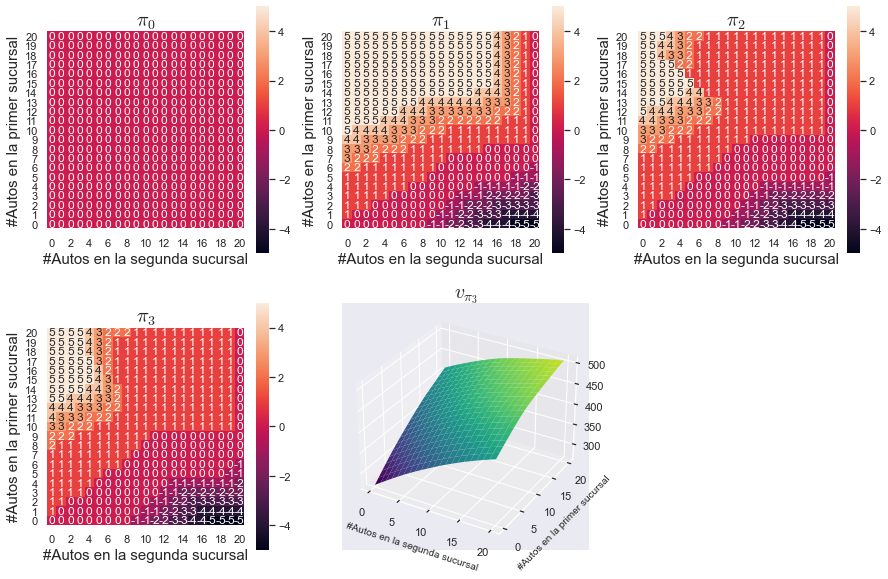

In [9]:
V, policy = policy_iteration(initialization=initialization_car_rental, q=q_car_rental_v2, A=A_car_rental, S=CAR_RENTAL_STATES, 
                             init_plots=init_plots_car_rental_v2, plot_policy=plot_policy_car_rental, plot_state_values=plot_state_values_car_rental, theta=0.1)

Ahora el algoritmo converge en 3 iteraciones y la política óptima obtenida es distinta a la del problema sin las modificaciones. Por un lado, ahora siempre que la cantidad de autos en la primera sucursal es mayor que en la segunda, conviene mover, por lo menos un auto. Esto se puede explicar por la nueva condición de que el primer auto que se mueve de la primera sucursal a la segunda es gratis, y como el número de autos en la segunda sucursal tiende a disminuir más que en la primera, en general va a convenir usar ese movimiento gratis. Por otro lado, en la política anterior, no convenia mucho mover autos de la segunda sucursal a la primera, en particular, nunca convenia mover 5 autos en esa dirección. Pero ahora, debido a la condición de que se debe pagar estacionamiento extra para más de 10 autos, cuando hay pocos autos en la primera sucursal y muchos en la segunda, conviene moverlos más que antes, en particular, hay casos donde conviene mover hasta 5 autos.

### Conclusión

Los métodos de programación dinámica, como el que implementamos en este trabajo, son simples y efectivos. En el problema del alquiler de autos de Jack, la política obtenida nos dice exactamente qué hacer en cada situación posible para optimizar la ganancia y además converge en pocas iteraciones. 

Sin embargo, el requerimiento de poseer un modelo completo de la dinámica del sistema en terminos de un MDP finito es poco realista, y aún cuando se posee dicho modelo, puede ser muy costoso computacionalmente resolverlo. Con lo cual, en realidad, su utilidad práctica es limitada.

Aún así, estos algoritmos clásicos de programación dinámica siguen siendo importantes teoricamente, ya que proveen una base para otros métodos como la iteración de valor o la programación dinámica asíncrona, que buscan el mismo efecto pero incorporando optimizaciones para utilizar menos poder de cómputo o no asumir un modelo completo del sistema.

### Referencias

* Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). The MIT Press.
* El código para graficar y la simplificación de dejar constante la cantidad de autos retornada están basadas en https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter04/car_rental.py